# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1
### Loading data

We selected randomly 100 tickers out of the provided set by the sample() function without replacement, using the SIS number of Matyáš as a seed. We downloaded data for selected tickers from yahoo finance, using the functionality of quantmod package, and restricting the time range to the one specified in the assignment.

In [54]:
#Loading necessary packages
suppressPackageStartupMessages({
library(quantmod)
library(rugarch)
})

In [2]:
#Loading the file containing the symbols
symbols2 <- read.csv("symbols2.csv")

#Generating 100 random numbers
set.seed(48983854) #random seed using the SIS number
indices <- sort(sample(1:377, 100, replace = F)) #geting sample, sorting from lowest to highest

#Extracting the tickers
tickers <- symbols2$Symbol[indices]

#Downloading the data for each ticker
tickers_data <- vector("list", length(tickers)) #Empty list for the data
options("getSymbols.warning4.0" = FALSE) #To suppress an annoying message
for (i in 1:length(tickers)) {
    tickers_data[[i]] <- getSymbols(tickers[i], src = "yahoo", auto.assign = F, from = "2019-01-01", to = "2022-01-01")
}

Warning message:
"BMS contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


Further, we work only with the closing prices adjusted for splits and dividends (and/or capital gain distributions). This variable is (in case of yahoo finance) standardly located in the sixth column but, for completness, we include a check of this in the next cell.

In [3]:
#Check that the adjusted closing price is in the sixth column
sixth_cols <- vector("character", length(tickers_data))
is_adjusted <- vector("character", length(tickers_data))

for(i in 1:length(tickers_data)) {
 sixth_cols[i] <- names(tickers_data[[i]])[6]
}

for(i in 1:length(tickers_data)) {
 is_adjusted[i] <- substr(sixth_cols[i],  nchar(sixth_cols[i])-nchar("Adjusted")+1, nchar(sixth_cols[i])) #selecting only last eight characters of each column name
}

sum(is_adjusted == "Adjusted") #If we get here sum of 100, we got all the adjusted closing prices in the sixth column and can continue with the analysis

[1] 100

In [4]:
#Merging into a single xts object
adjusted_prices <- merge.xts(tickers_data[[1]][, 6], tickers_data[[2]][, 6]) #Initial merge
for (i in 3:100) { #Loop to merge all 100 tickers
    adjusted_prices <- merge.xts(adjusted_prices,tickers_data[[i]][, 6])
}

### 1) Log-returns

In [5]:
#Matyáš řešení
log_returns_M <- log(adjusted_prices) - log(lag(adjusted_prices))

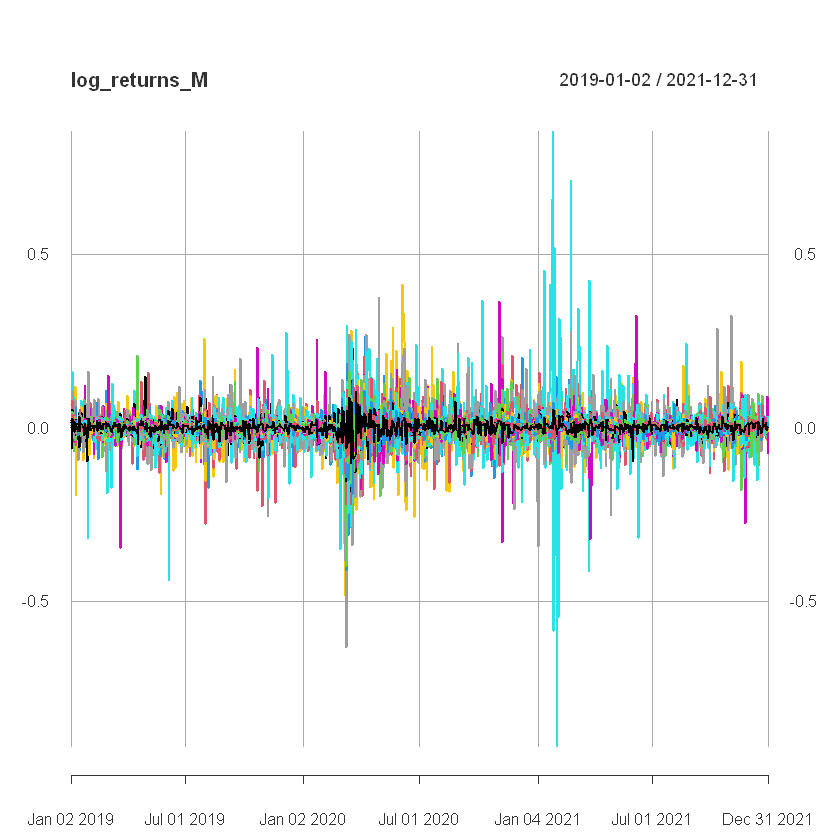

In [6]:
plot(log_returns_M)

Bellow, we compute the logarithmic returns on the stocks of our interest. This is done so using the formula for logarithmic returns: $log(r_t) = log(\frac{P_t}{P_{t-1}}) = log(P_t) - log(P_{t-1})$.

In [7]:
#Creating list containing Log-returns
log_returns <- vector("list", length(tickers_data)) #initializing empty list, to be filled with dataframes

for(i in 1:length(tickers_data)) {
    obs <- length(tickers_data[[i]][,6]) #number of observations of adjusted close price for ith ticker
    lrets <- vector("numeric", obs)
    lrets[1] <- NA

    for(n in 2:obs){
        lrets[n] <- as.numeric(log(tickers_data[[i]][n,6])) - as.numeric(log(tickers_data[[i]][n-1,6])) #cpmuting the log-returns
    }

    log_returns[[i]] <- data.frame(Date = index(tickers_data[[i]]), tickers_data[[i]][,6], Log_returns = lrets) #saving log-returns and othe info in dataframe
}

#Each element of the list log_returns is a dataframe, containing dates, original closing prices and logarithmic returns
#(the original prices is included mainly so the firm it belongs to could be easily recognized by ticker)

For ilustration, log-returns of on randomly selected stock are plotted bellow.

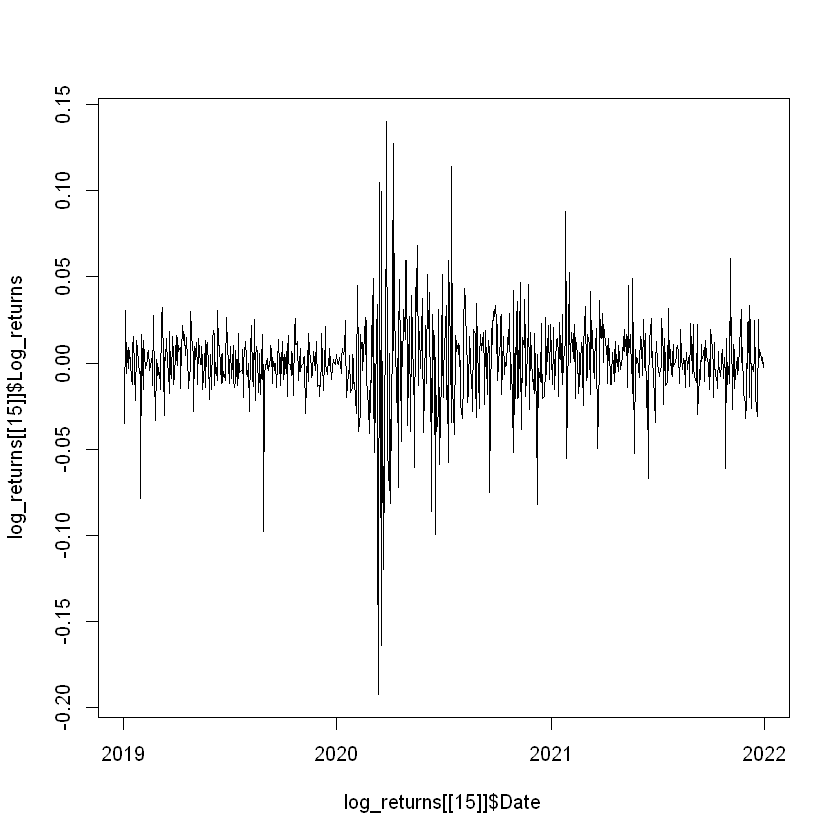

In [8]:
#Example of Log-Return series
plot(x=log_returns[[15]]$Date, y=log_returns[[15]]$Log_returns, type="l")

In [9]:
#Just some notes

#plot ACF and PACF of logrets? or logrets^2?
#lagrange multiplier test for ARCH effect? (arch.test)?
#alpha - effetc of past excess return (ret. different from mean), beta - effect of variance (volatility) from the previous period

### 2) Estimating GARCH(1,1) models

In this section, we estimate 100 GARCH(1,1) models (one for each stock). The GARCHes estimated are of standard form:

$
r_t = \mu_t + a_t \\
a_t = \sigma_t\epsilon_t \\
\sigma^2_t = \alpha_0 + \alpha_1a^2_{t-1} + \beta_1\sigma^2_{t-1}
$ where $(\alpha_1 + \beta_1) < 1$.

 For the estimation, we use functions from ugarch package. In arguments of the fitting function, we set solver to "hybrid", in order to assure convergence (this solver iterates through several other solvers and chooses the convergin one).

In [55]:
#Estimating GARCH(1,1) models and saving fitted objects in list
garch_list <- vector("list", length(tickers_data)) #empty list, to be filled with fitted-model objects

for(i in 1:length(tickers_data)){
    garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
    garch_fit <- ugarchfit(garch_spec, na.omit(log_returns[[i]]$Log_returns),solver="hybrid") #solver="hybrid" to ensure convergence

    garch_list[[i]] <- garch_fit
}

### 3) Extracting and plotting alphas and betas

In this section, we extract the estimated parameters from fitted models and plot their histograms.

In [56]:
#Initializing empty dataframe
coef_df <- data.frame(Firm = tickers, 
                    alphas = rep(NA, length(tickers_data)), 
                    betas = rep(NA, length(tickers_data)), 
                    ab_sum = rep(NA, length(tickers_data)))

#filling the dataframe with the estimated aplphas, betas, and their sums
for(i in 1:length(tickers_data)){
    coef_df$alphas[i] <- as.numeric(coef(garch_list[[i]])[3])
    coef_df$betas[i] <- as.numeric(coef(garch_list[[i]])[4])
    coef_df$ab_sum[i] <- as.numeric(coef(garch_list[[i]])[3]) + as.numeric(coef(garch_list[[i]])[4])
}                    

Bellow, histograms are displayed. From the definition of the GARCH(1,1) model, we know that $\alpha + \beta < 1$. Keeping this information in mind, we can observe that estimated alphas attain relatively small values (most frequently between 0.1 and 0.2), while betas relatively large values (concentrated around 0.8). 

In the GARCH model, $\alpha$ represents the effect of the excess squared return $a^2$ in period $t-1$ on the volatility $\sigma^2$ in period $t$, and $\beta$ represents the effect of $\sigma^2_{t-1}$ on $\sigma^2_t$. Therefore, based on the models estimated we could assume that for most stocks, the effect of past excess returns on the volatility will be present, but not very strong, while the effect of volatility on itself will be dominant. This also supports empirically observed volatility clustering, according to which the large (small) price changes tends to be followed by large (small) price changes as well. 

From the histogram of $(\alpha+\beta)$ values, we can see that for the majority of fitted models the sum is close to 1 (mostly concentrated around 0.95). The condition $(\alpha_1 + \beta_1) < 1$ ensures that conditional variance of $a_t$, $\sigma^2_t$, does not diverge, but converge to unconditional variance $\alpha_0$ in infinity. Therefore, as the sum tends to be close to 1, we can assume that $\sigma^2_t$ will convergence only slowly, past mean corrected returns $a^2_{t-1}$ will play an important role, and/or the effect of $\sigma^2_{t-1}$ (variance clustering effect) will be prominent.

There are also outliers in the vectors of alphas and betas, but these are explored in the next section.

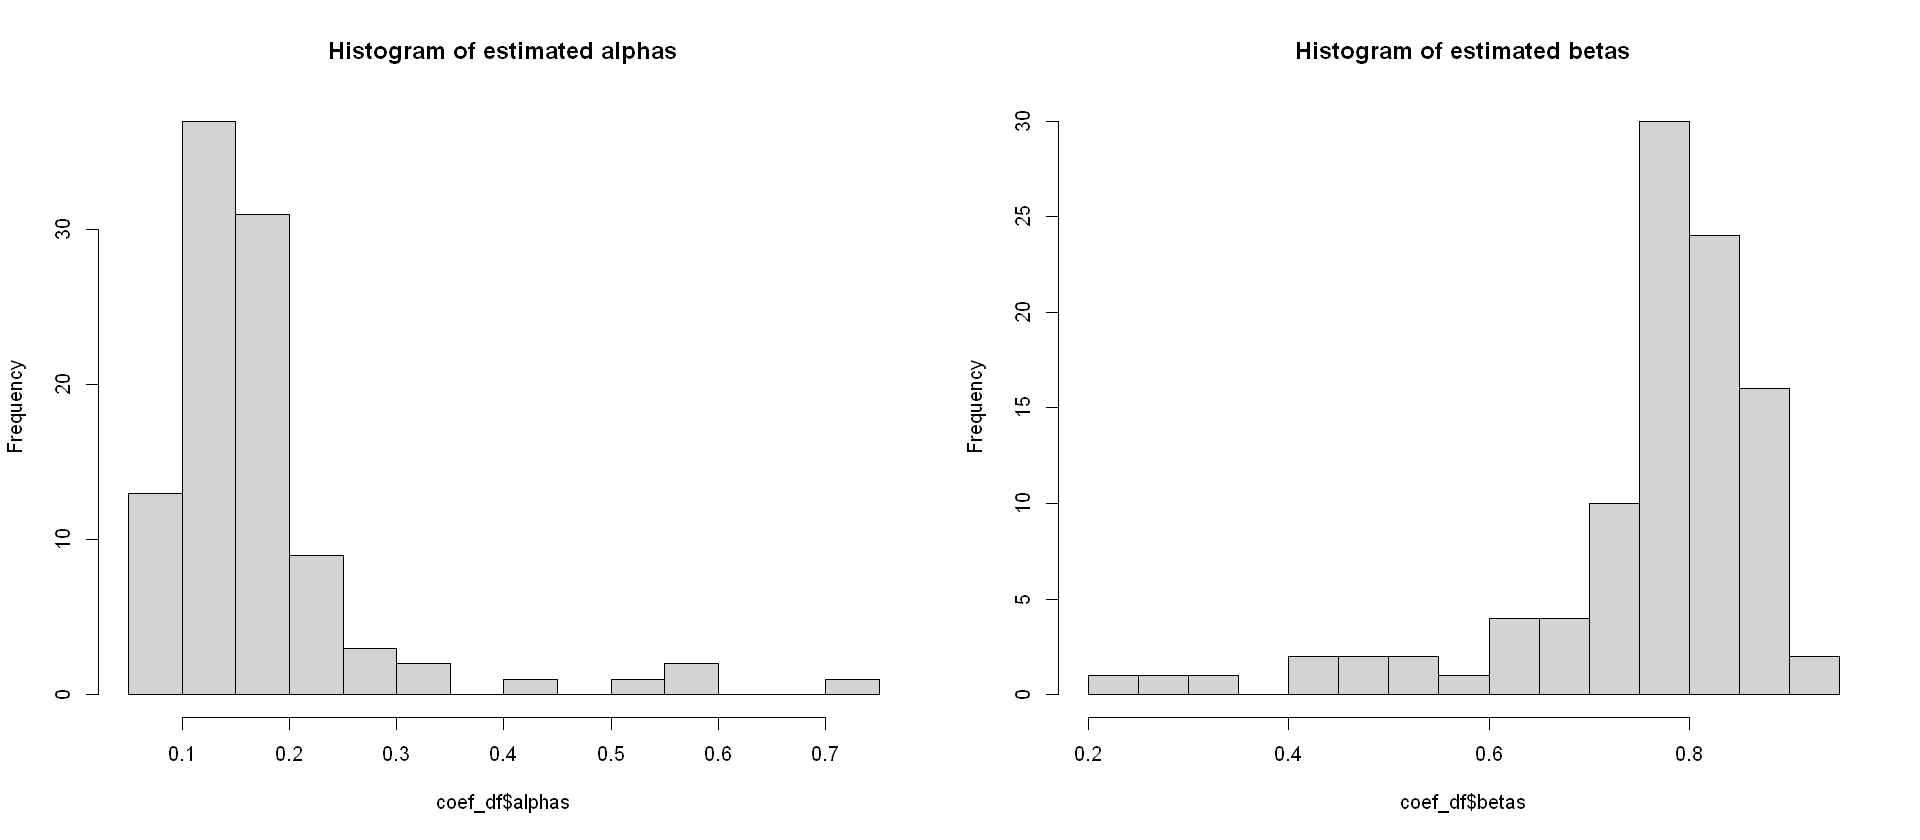

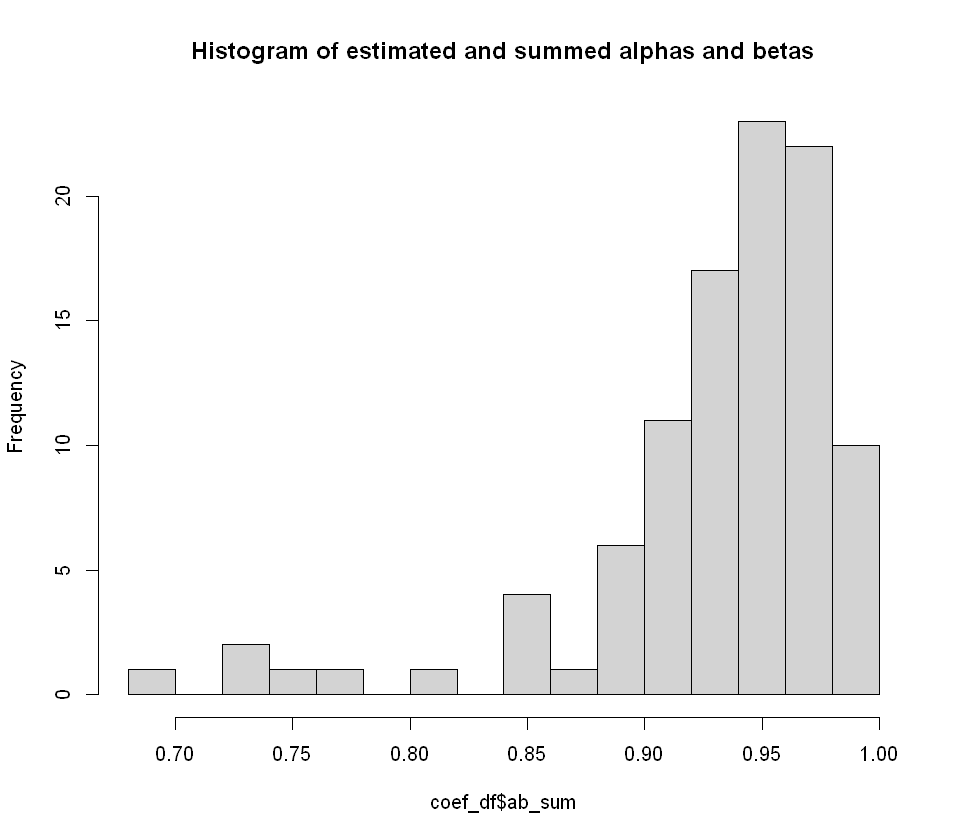

In [14]:
#ploting the crossection of coefficients
options(repr.plot.width = 16, repr.plot.height = 7)
par(mfrow = c(1, 2))
hist(coef_df$alphas, breaks = 10, main = "Histogram of estimated alphas")
hist(coef_df$betas, breaks = 10, main = "Histogram of estimated betas")
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow = c(1, 1))
hist(coef_df$ab_sum, breaks = 11, main = "Histogram of estimated and summed alphas and betas")

### 4) Maximum estimated coefficients

Following directly from the pevious section, here we show smallest and largest values of estimated parameters.

In [62]:
#alpha
m_a <- max(coef_df$alphas)
m_a_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a, coef_df$alphas)]]
m_a_min <- min(coef_df$alphas)
m_a_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a_min, coef_df$alphas)]]

#beta
m_b <- max(coef_df$betas)
m_b_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b, coef_df$betas)]]
m_b_min <- min(coef_df$betas)
m_b_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b_min, coef_df$betas)]]

#sums
m_ab <- max(coef_df$ab_sum)
m_ab_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab, coef_df$ab_sum)]]
m_ab_min <- min(coef_df$ab_sum)
m_ab_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab_min, coef_df$ab_sum)]]

#alpha
print(paste("Maximum estimated alpha:", m_a, "for firm", m_a_name))
print(paste("Minimum estimated alpha:", m_a_min, "for firm", m_a_name_min))

#beta
print(paste("Maximum estimated beta:", m_b, "for firm", m_b_name))
print(paste("Minimum estimated beta:", m_b_min, "for firm", m_b_name_min))

#sums
print(paste("Maximum estimated sum:", m_ab, "for firm", m_ab_name))
print(paste("Minimum estimated sum:", m_ab_min, "for firm", m_ab_name_min))

[1] "Maximum estimated alpha: 0.730048988013442 for firm Hasbro Inc."
[1] "Minimum estimated alpha: 0.0575178850190578 for firm Newmont Mining Corp. (Hldg. Co.)"
[1] "Maximum estimated beta: 0.916040531108589 for firm Ryder System"
[1] "Minimum estimated beta: 0.231069719504805 for firm Hasbro Inc."
[1] "Maximum estimated sum: 0.998999981758519 for firm Host Hotels & Resorts"
[1] "Minimum estimated sum: 0.698997274801342 for firm Intel Corp."


Interpretation of maximal and minimal values of estimated coefficients stems from their properties described above. 

* In the case of Hasbro Inc. (largest alpha and smallest beta), we can assume that variance of log-returns on the firm's stock will be heavily affected by bast mean-corrected returns, while the volatility clostering effect will be weak.

* For the Newmont Mining Corp. (smallest alpha), we could expect the variance $\sigma^2_t$ to be only very weakly dependent on the past returns.

* Rider Systems' return volatility will likely suffer of strong volatility clustering effect, as values of $\sigma^2_t$ will probably be strongly affected by $\sigma^2_{t-1}$ (largest beta).

* For the Host Hotels & Resorts (largest sum of alpha and beta), we can assume the volatility converge to unconditional volatility very slowly, the effect of past returns and volatility clustering being strong.

* On the other hand, in case of Intel Corp. (smallest sum), the $\sigma^2_t$ will likely converge to $\alpha_0$, and the effect of $a_{t-1}$ and volatility clustering will be weak.

### 5) Estimated volatility averaged 

Here, we extract the estimated volatilities from the GARCH(1,1) models, and next take the mean, 5%, and 95% quantiles for each day.

In [16]:
#Extracting the volatilities
volatilities <- vector("list", length(garch_list))
for (iter in 1:length(garch_list)) {
    vol <- rep(NA, length(index(na.omit(tickers_data[[iter]]))))
    vol[2:length(vol)] <- as.numeric(sigma(garch_list[[iter]]))
    volatilities[[iter]] <- data.frame(Date=index(na.omit(tickers_data[[iter]])),Volatility=vol)
}

In [59]:
#Computing the quantiles
days <- seq(from = as.Date("2019-01-01"), to = as.Date("2021-12-31"), by="day")
five_percent <- rep(NA, length(days))
medians <- rep(NA, length(days))
ninety_five_percent <- rep(NA, length(days))
for (iter_day in 1:length(days)) { #For each day
    daily_vol <- rep(NA, 100) #Empty vector for daily volatilities accross tickers
    for (iter_ticker in 1:100) { #For each ticker check if the value exists
        if (days[iter_day] %in% volatilities[[iter_ticker]]$Date) {
            #daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[iter_day] #corecting bug that was on this line (subseting vector of length 757 by numbers 757+)
            daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[volatilities[[iter_ticker]]$Date == days[iter_day]]
    } else {
        daily_vol[iter_ticker] <- NA
    }
    }
    five_percent[iter_day] <- quantile(daily_vol, probs = 0.05, na.rm = TRUE)
    medians[iter_day] <- quantile(daily_vol, probs = 0.5, na.rm = TRUE)
    ninety_five_percent[iter_day] <- quantile(daily_vol, probs = 0.95, na.rm = TRUE)
    #print(summary(daily_vol))
}

In the following cell, the estimated "market" volatility is estimated. The mean volatility is shown in black, the 5% and 95% quantiles in gray, therefore together the plot shows a "90% confidence band" for the true market volatility (please keep in mind that such intepretation is just a heuristics).

To comment on the volatility values themselves, we can observe that at the first quarter of 2020, there was an extreme spike in market volatility, very likely caused by the break-out of the Covid-19. Since then, variance slowly returned to its pre-coivd values. The Volatility clustering is from the plot also visible, the increased volatility is likely to be again followed by increased volatility.

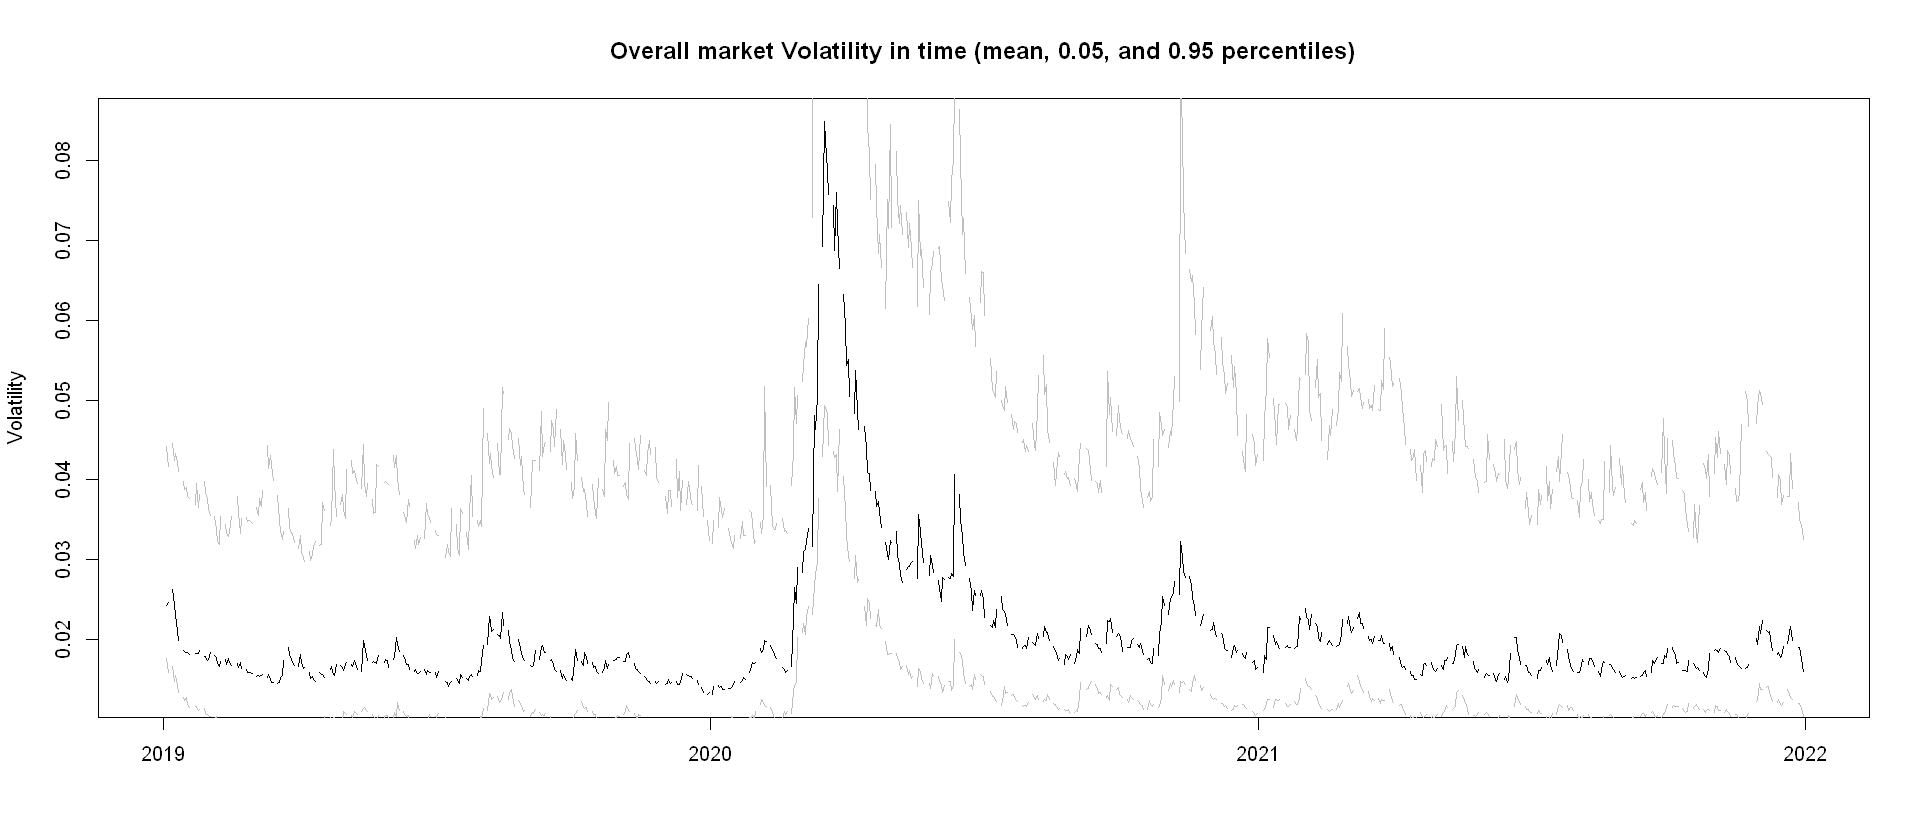

In [64]:
plot(x = days, y = medians, type = "l", main = "Overall market Volatility in time (mean, 0.05, and 0.95 percentiles)", xlab = "", ylab="Volatility")

lines(x = days, y = five_percent, type = "l", col = "grey")
lines(x = days, y = ninety_five_percent, type = "l", col = "grey")

In [65]:
###  Remove?

#par(mfrow=c(2,2))
#hist(five_percent)
#hist(medians)
#hist(ninety_five_percent)

### Problem 2

In [32]:
#Computing the means
log_returns_means <- apply.daily(log_returns_M, function(x) mean(c(x), na.rm = TRUE))

In [36]:
summary(log_returns_means)
#hist(log_returns_means)

     Index            log_returns_means   
 Min.   :2019-01-02   Min.   :-0.1367963  
 1st Qu.:2019-10-02   1st Qu.:-0.0060408  
 Median :2020-07-02   Median : 0.0011411  
 Mean   :2020-07-02   Mean   : 0.0006761  
 3rd Qu.:2021-04-05   3rd Qu.: 0.0081388  
 Max.   :2021-12-31   Max.   : 0.1169785  
                      NA's   :1           

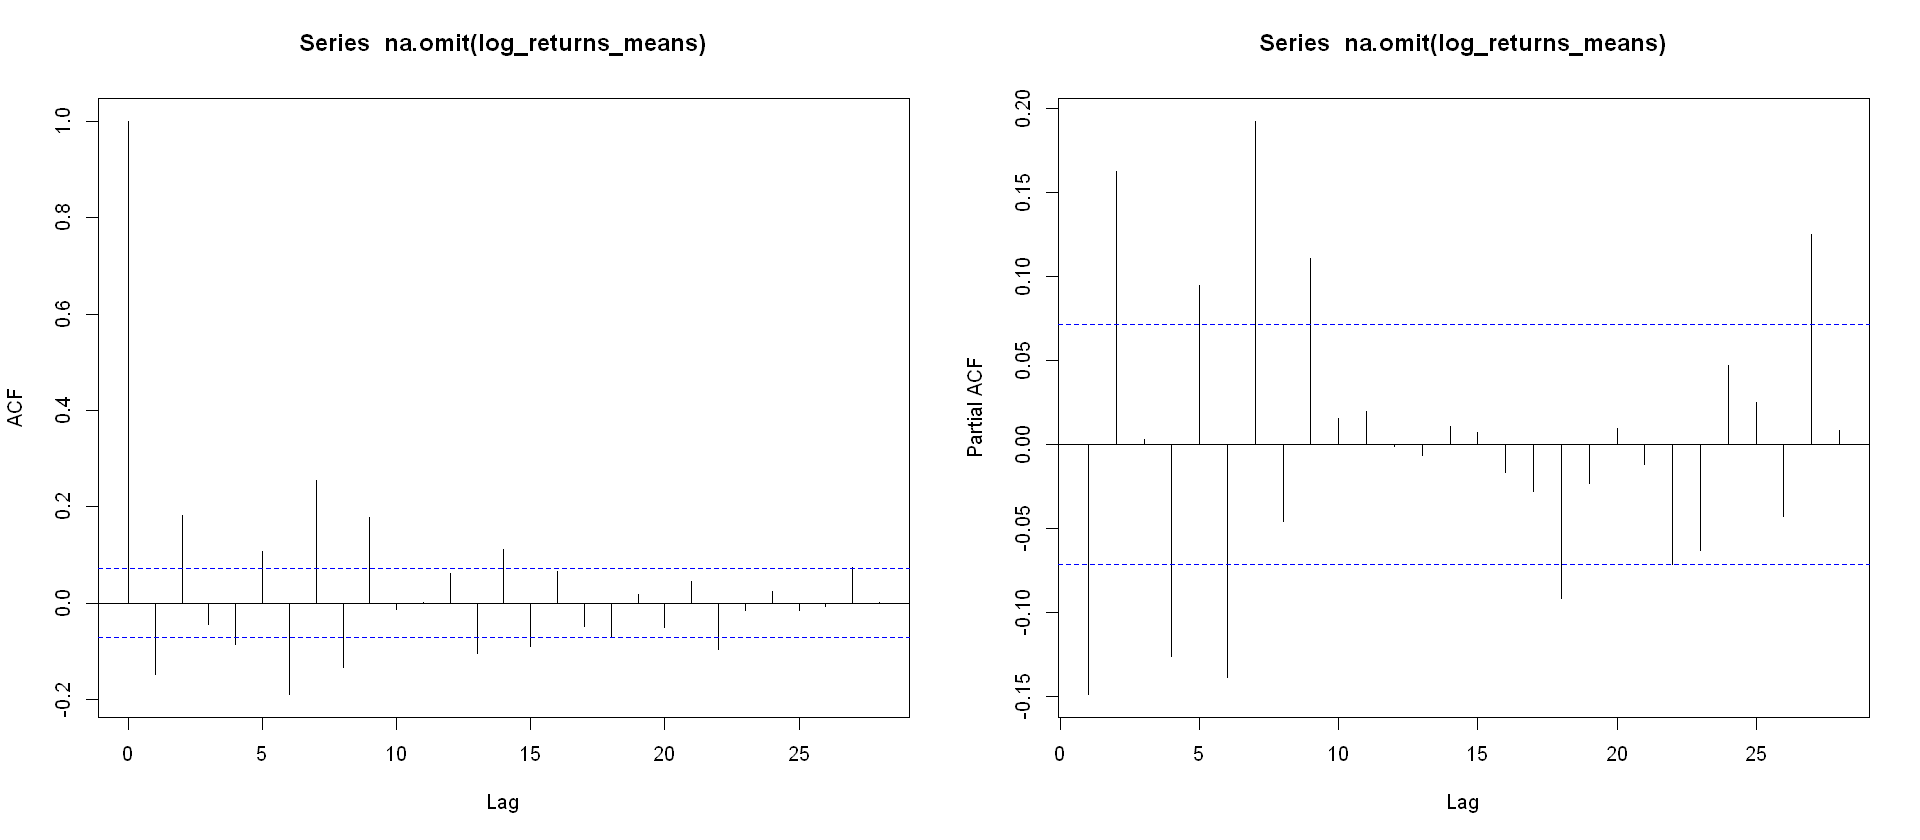

In [50]:
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(na.omit(log_returns_means))
pacf(na.omit(log_returns_means))